# Genetic Programming

Today we will practice genetic programming on the problem of symbolic regression (i.e., finding a formula that fits the given data) and classification, i.e., finding a decision tree using genetic programming. We will use the `deap` library, which we briefly demonstrated last time.

We will start by importing and generating the data we will use for the regression.

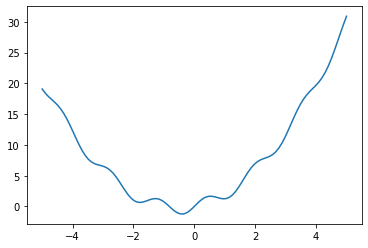

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.plot(x_train, y_train)
plt.show()

Let's prepare a helper function to display the created tree. This uses the pydot library (and the GraphViz program) to draw graphs. If you install pydot using `conda`, graphviz should be installed automatically. `conda` is a package manager similar to `pip`, just more powerful. It has its own virtual environments, integrates well with PyCharm or VS Code, and sometimes makes things easier (e.g. making GPU work with PyTorch for neural nets out of the box).

Note that installing graphviz on Windows may be great pain, so alternatively, copy this notebook to [Colab](colab.research.google.com/).

In [19]:
import pydot
from IPython.display import Image

# display the individual as a tree
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

When working with genetic programming, we need to create a set of primitives - terminals and non-terminals that evolution will work with. There is a class `gp.PrimitiveSet` in `deap` for this, or `gp.PrimitiveSetTyped` for typed GPs. We'll show the typed case here because it's more general. But we'll only use one type, so there's actually no need.

In [20]:
import operator

from deap import gp

pset = gp.PrimitiveSetTyped('MAIN', [float], float) # the name of the set is MAIN, there is one float input and one float output
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)

In [21]:
from deap import creator, base, tools, algorithms

#define fitness - it computes the MSE and individual size, the weights are set below to (-1.0 a -0.01)
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # compile can be used to transform the individual into a function callable in Python
    vals = list(map(func, x))
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#set up the algorithm
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#limit the depth of the tree
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [22]:
pop = toolbox.population(n=100)
#save the best solution
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max  	min    	nevals	std    	avg  	gen	max	min	nevals	std    
0  	100   	450.702	0  	20647	36.1237	100   	2342.97	71.35	0  	464	4  	100   	101.478
1  	57    	106.867	1  	121.422	9.97719	57    	18.6683	59.17	1  	454	3  	57    	96.8802
2  	60    	98.7399	2  	271.486	9.97719	60    	29.8964	39.09	2  	435	2  	60    	65.265 
3  	64    	83.7491	3  	167.366	9.97719	64    	30.9439	27.43	3  	434	4  	64    	44.7223
4  	48    	65.1806	4  	241.988	9.97719	48    	34.913 	19.15	4  	38 	7  	48    	5.89131
5  	56    	57.3903	5  	470.376	9.97719	56    	55.6042	18.86	5  	33 	7  	56    	5.52453
6  	50    	40.4507	6  	230.388	7.03293	50    	41.4396	18.58	6  	37 	9  	50    	5.15593
7  	45    	40.2474	7  	472.543	7.03293	45    	61.2852	17.77	7  	38 	7  	45    	6.01474
8  	56 

Let us show the best individual at the end of evolution.

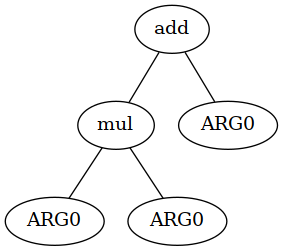

In [23]:
Image(plot_tree(hof[0]))

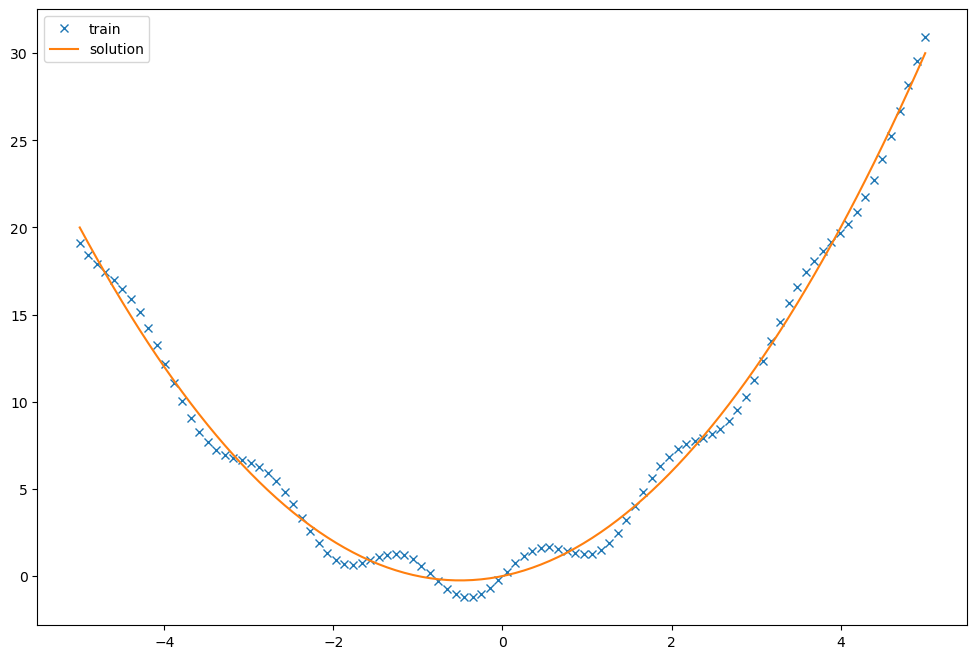

In [24]:
# compare the function we found with the training data
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'x', label='train')
plt.plot(x_train, y, label='solution')
plt.legend()
plt.show()

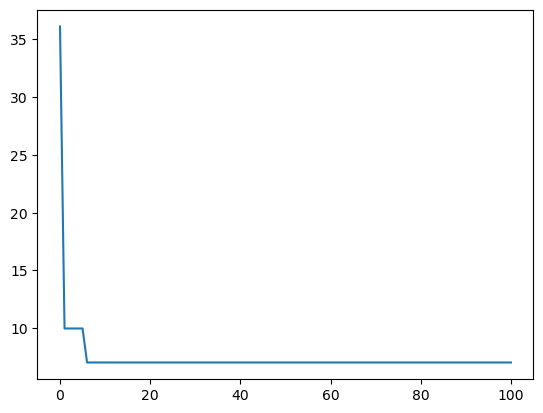

In [25]:
plt.plot([l['min'] for l in log.chapters['fitness']])

## Exercise

Try using genetic programming to solve the classification problem, e.g. for a dataset with irises. Think about how to define a set of primitives and fitness. Implement and run the algorithm.

https://scikit-learn.org/stable/datasets/toy_dataset.html

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y= load_iris(return_X_y=True)